###Delta Task 2 -Busra Kasbali

In [41]:
### Python Version: 3.11.13

In [43]:
import pandas as pd
import numpy as np
import re
import nltk
import sklearn
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import wordninja


In [44]:
#Reading train and test sets into data frame

btc_tweets_train = pd.read_parquet('btc_tweets_train.parquet.gzip')
btc_tweets_test = pd.read_parquet('btc_tweets_test.parquet.gzip')

### Exploratory Analysis to Understand the Data

First start with the exploratory data analysis to understand the data structure. Both training and test data has 5 columns and 1500 observations in train and 500 in test set.

In [45]:
btc_tweets_train.info()
btc_tweets_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 1641579121972236290 to 1641861677149822976
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   hashtags          1500 non-null   object
 1   content           1500 non-null   object
 2   username          1500 non-null   object
 3   user_displayname  1500 non-null   object
 4   sentiment         1500 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 60.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1641861708246552576 to 1641953216999968769
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   hashtags          500 non-null    object
 1   content           500 non-null    object
 2   username          500 non-null    object
 3   user_displayname  500 non-null    object
 4   sentiment         500 non-null    bool  
dtypes: bool(1), object(4)
memory usage

Content column has the content for sentiment analysis. The tweets include hashtags, emojis and line break elements, which may require handling before we start on tokenizing our data. And it is a mix of uppercase and lower case values

In [46]:
btc_tweets_train['content'][1641861088483368964]

'Last chance below 30k #BITCOIN\u202f\u202f\u202f #LFG \nSet a reminder for my upcoming Space! https://t.co/rnE6XDLOPH'

The data frame has an index column and the indexes for observations are the tweet_ID

In [47]:
btc_tweets_train.head(10)

,hashtags,content,username,user_displayname,sentiment
tweet ID,,,,,
1641579121972236290,"[Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...","$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,SHIB Bezos,True
1641579176171016194,"[Bitcoin, bitcoinordinals, crypto]",Alright I have my rares. Who else is grabbing ...,spartantc81,SpartanTC,True
1641579486071390208,"[BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...","Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,SHIB Bezos,True
1641579537103302656,[BTC],📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,Algorithm.btc,True
1641579588399804418,[Bitcoin],"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,she is lucky,True
1641579652681543680,"[Crypto, Bitcoin, Investing]",Unpopular opinion:\n\nThis pump isn’t going to...,CloseSomeSayles,Andrew Sayles☕,False
1641579895615569921,[Bitcoin],#Bitcoin fixes this,ShannenJPEG,Shannen 🍉,True
1641580545678393345,[Bitcoin],Solid bid in major ALT/BTC pairs today. \n\nIf...,tedtalksmacro,tedtalksmacro,True
1641580600606769152,[bitcoin],"If you're filing 2022 taxes in the U.S., you s...",unchainedcom,Unchained,True


The sentiment of the content is already a boolean so dont need to change that. The train set consists heavily of positive sentiment score

In [48]:
btc_tweets_train.describe()

,hashtags,content,username,user_displayname,sentiment
count,1500,1500,1500,1500,1500
unique,945,1500,1012,1012,2
top,[Bitcoin],If the government are allowed to sell all the ...,BezosCrypto,SHIB Bezos,True
freq,384,1,41,41,1220


### Preprocessing Function

In [49]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [50]:
# Creating a POS Tag (Part of Speech tagging) to use in lemmatization

def get_wordnet_pos(word:str)->str:
    """Map POS tag to first character for lemmatization

    Returns:
    --------
    pos: str
        The positional tag of speech retrieved from wordnet database.
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    pos=tag_dict.get(tag,wordnet.NOUN)

    return pos

In [51]:
def NLP_preprocessing_pipeline(sample:str)->str:
    '''
    Implements a NLP preprocessing pipeline specific for tweets from twitter.

    Parameters:
    -----------
    sample:str
        The input text that requires preprocessing

    Returns:
    --------
    preprocessed_textual_sample:str
        The cleaned version of the tweet as a string after preprocessing steps have been applied.

    '''

    #Preprocessing steps:

    #Removing of URLs:
    preprocessed_textual_sample = re.sub("http\S+"," ",sample)

    #Changing all tokens to lower case
    preprocessed_textual_sample = preprocessed_textual_sample.lower()

    #Removing the line breaks:
    preprocessed_textual_sample = preprocessed_textual_sample.replace('\n'," ")

    #Removing hashtags while replacing the rest of the hastag with the splitted version of the words in hashtag
    hashtags = re.findall(r'#\w+', preprocessed_textual_sample)
    for tag in hashtags:
      words_in_hashtag = wordninja.split(tag[1:])
      preprocessed_textual_sample = preprocessed_textual_sample.replace(tag, ' '.join(words_in_hashtag))

    #Removing of non-alphabetic characters except numbers:
    preprocessed_textual_sample = re.sub(r"[^a-zA-Z0-9,.]", " ", preprocessed_textual_sample) #keeping ',' and '.' to not split numbers like 100,000

    #Tokenization:
    preprocessed_textual_sample = nltk.word_tokenize(preprocessed_textual_sample)

    #Stopwords removal:
    words_without_stopwords = []

    for w in preprocessed_textual_sample:
      if w not in stopwords.words("english"):
        words_without_stopwords.append(w)

    #Now removing '.' and ',' from tokens
    words_without_stopwords = [words for words in words_without_stopwords if words != '.']
    words_without_stopwords = [words for words in words_without_stopwords if words != ',']

    preprocessed_textual_sample = words_without_stopwords

    # Lemmatize with POS Tag (Parts of Speech tagging)
    lemmatizer = WordNetLemmatizer()
    preprocessed_textual_sample = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in preprocessed_textual_sample]

    #Join the tokens to create a cleaned version of strings to use in Keras Tokenizer
    preprocessed_textual_sample = ' '.join(preprocessed_textual_sample)

    return preprocessed_textual_sample


In [52]:
#Creating the preprocessed train and test sets with the preprocessing function
x_tweets_clean_train =  btc_tweets_train['content'].apply(NLP_preprocessing_pipeline)
x_tweets_clean_test =  btc_tweets_test['content'].apply(NLP_preprocessing_pipeline)

#Creating a df for the sentiment labels of train and test sets
y_tweets_train = btc_tweets_train['sentiment']
y_tweets_test = btc_tweets_test['sentiment']

In [53]:
x_tweets_clean_test

,content
tweet ID,
1641861708246552576,crypto crypto btc chinese crypto alpha althoug...
1641861783898972167,bitcoin would fall another 80 reach low 3 year...
1641862152532418562,giveaway 1000 matic 3days win 1 follow matic 2...
1641862338369183753,eos eos v usdt usd btc btc crypto bitcoin e ri...
1641862430434131968,mid day mix live never know might stop btc eth...
...,...
1641952735653421056,u government put guy jail 2 life sentence crea...
1641952895112290305,bitcoin embrace
1641952949763973122,onward upward babe love stamp love ordinal lov...


### Dictionary Based Sentiment Analysis

In [54]:
import pysentiment2 as ps
dictionary = ps.HIV4()

#Creating a function for sentiment score assesment using a dictionary
def get_sentiment_score(text):
  score = round(dictionary.get_score(dictionary.tokenize(text))['Polarity'], 2)
  return score

#Assesing polarity scores using sentiment dictionary
dc_test_sentiment_scores = x_tweets_clean_test.apply(get_sentiment_score)


<Axes: >

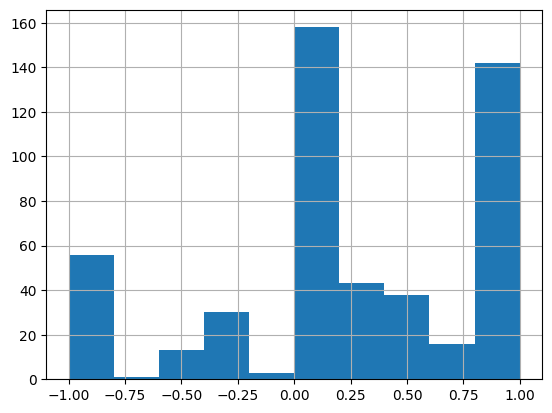

In [55]:
dc_test_sentiment_scores.hist()

### Function for Assesing Sentiment Classifier

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def assess_sentiment_classifier(y_test, y_pred_prob, cut_off=0.5, plot_roc=True):
    """
        Function to assess the classification results from the model.
        Calculates accuracy score, roc auc score and confusion matrix.
        Plots a roc curve when true.

    """
    # Calculate discrete class predictions
    y_pred_discrete = np.where(y_pred_prob>cut_off, 1, 0)

    # Calculate classification accuracy and AUC
    acc = round(accuracy_score(y_test, y_pred_discrete),4) #accurately predicted ones: TP+TN/all sample
    auc = round(roc_auc_score(y_test, y_pred_prob),4) #TP/FP

    # Confusion matrix
    cmat = confusion_matrix(y_test, y_pred_discrete)

    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')
        plt.xlabel('False positive rate')
        plt.legend(loc='lower right')
        plt.show();

    return(auc, acc, cmat)

### Assessing Dictionary Based Sentiment Classifier

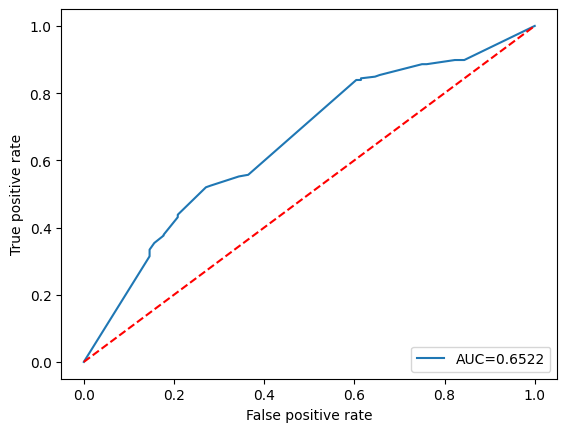

(np.float64(0.6522),
 0.572,
 array([[ 61,  35],
        [179, 225]]))

In [57]:
#We make the cut_off=0 because the dictionary returns score in range (-1,1) where score<0 is negative while score>0 is positive
assess_sentiment_classifier(y_tweets_test, dc_test_sentiment_scores, cut_off = 0,plot_roc=True)

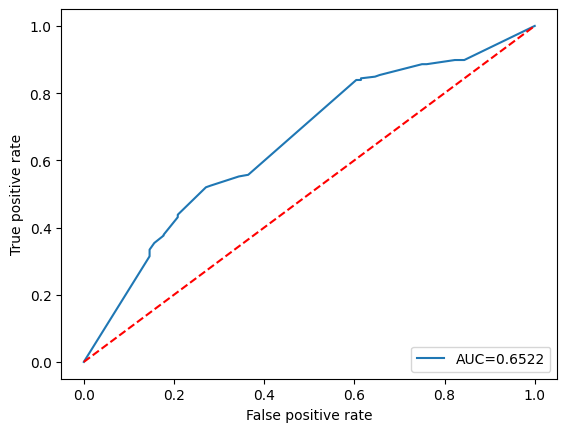

In [58]:
auc_dict, acc_dict, _ = assess_sentiment_classifier(y_tweets_test, dc_test_sentiment_scores, cut_off = 0,plot_roc=True)

In [59]:
#Creating an empty data frame for results
df_scores = pd.DataFrame(index=['ACC', 'AUC'])
df_scores['Dictionary'] = [acc_dict,auc_dict]

### Document Level Sentiment Analysis Using TF-IDF Vectorizer

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def dummy_fun(content):
    return content

tfidf_vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = nltk.word_tokenize,
    preprocessor = dummy_fun,
    token_pattern = None)

#Feature Extraction Using TFIDF
x_tweets_clean_train_tfidf = tfidf_vectorizer.fit_transform(x_tweets_clean_train) #fit training data to create the vocabulary and transform
x_tweets_clean_test_tfidf = tfidf_vectorizer.transform(x_tweets_clean_test) #transform test data

#Fitting the training data into a logistic regression function
logit = LogisticRegression()
logit.fit(x_tweets_clean_train_tfidf,y_tweets_train)
tfidf_test_prob = logit.predict_proba(x_tweets_clean_test_tfidf)[:,1] #Probability of being positive
tfidf_test_discrete = np.where(tfidf_test_prob>0.5, 1, 0)

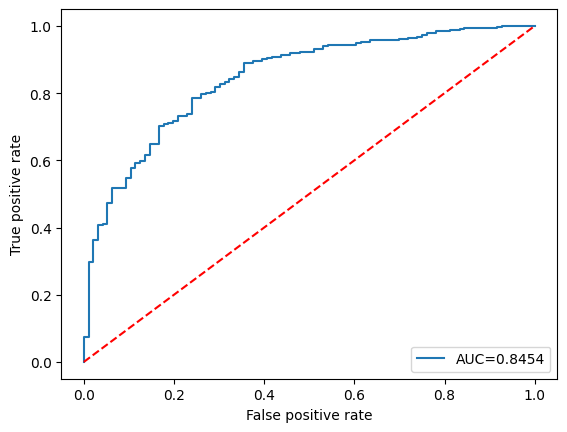

(np.float64(0.8454),
 0.812,
 array([[  2,  94],
        [  0, 404]]))

In [61]:
assess_sentiment_classifier(y_test=y_tweets_test,
                            y_pred_prob = tfidf_test_prob)

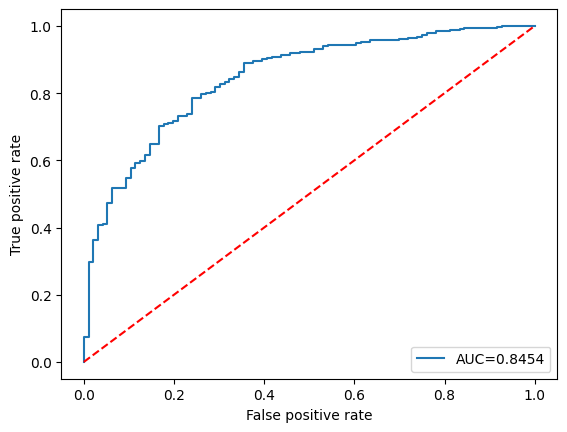

In [62]:
auc_tfidf, acc_tfidf, _ = assess_sentiment_classifier(y_test=y_tweets_test,y_pred_prob = tfidf_test_prob)

In [63]:
df_scores['TFIDF'] = [acc_tfidf,auc_tfidf]
df_scores

,Dictionary,TFIDF
ACC,0.5720,0.8120
AUC,0.6522,0.8454


### Processing Train & Test Sets to use in RNN

In [64]:
#Building vocabulary using Keras Tokenizer:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_word_number = 6000

# Create tokenizer object
tok = Tokenizer(vocab_word_number, oov_token=1)

# We fit the tokenizer to build vocabulary from the training set tweets
tok.fit_on_texts(x_tweets_clean_train)

In [65]:
#Number of unique words in the vocab
len(tok.word_counts)

5653

In [66]:
# Convert training set tweets to sequences of integer values
x_tweets_clean_train_int = tok.texts_to_sequences(x_tweets_clean_train)

# Determine the maximum review length in the training set
max_review_length = max([len(review) for review in x_tweets_clean_train_int])
print('The longest tweet of the training set has {} words.'.format(max_review_length))

The longest tweet of the training set has 52 words.


In [67]:
#Padding to create equal length tweets to ensure a consistent sequence length
from keras.preprocessing.sequence import pad_sequences

x_tweets_train_pad = pad_sequences(x_tweets_clean_train_int, max_review_length)

In [68]:
# Encoding and padding the test data set
x_tweets_clean_test_int = tok.texts_to_sequences(x_tweets_clean_test)
x_tweets_test_pad = pad_sequences(x_tweets_clean_test_int, max_review_length)

### RNN Language Classifier - Using Own Embeddings

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Flatten, Dropout, LSTM, Bidirectional
from keras.initializers import Constant

# Create an embedding layer
number_of_words = vocab_word_number
embedding_dim = 30
emb_layer = Embedding(input_dim = number_of_words,
                      output_dim= embedding_dim,
                      input_length= max_review_length)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [70]:
# GRU text classifier
number_hidden_nodes = 20    # number of hidden nodes

gru = Sequential()
gru.add(emb_layer)
gru.add(GRU(number_hidden_nodes))
gru.add(Dropout(0.2))
gru.add(Dense(1, activation = 'sigmoid'))

gru.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
print(gru.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [71]:
# fitting the model
nr_epoch = 10
batch_sz = 64
val_split = 0.25
story = gru.fit(x_tweets_train_pad, y_tweets_train, batch_size= batch_sz, epochs= nr_epoch, validation_split=val_split)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8151 - loss: 0.6358 - val_accuracy: 0.7520 - val_loss: 0.6039
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8338 - loss: 0.4859 - val_accuracy: 0.7520 - val_loss: 0.5675
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8338 - loss: 0.4122 - val_accuracy: 0.7520 - val_loss: 0.5620
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8338 - loss: 0.3775 - val_accuracy: 0.7520 - val_loss: 0.5344
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.8356 - loss: 0.3337 - val_accuracy: 0.7520 - val_loss: 0.5257
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8640 - loss: 0.2656 - val_accuracy: 0.7600 - val_loss: 0.5326
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9342 - loss: 0.1869 - val_accuracy: 0.7787 - val_loss: 0.4843
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9742 - loss: 0.1322 - val_accuracy: 0.7813

In [72]:
yhat_gru = gru.predict(x_tweets_test_pad)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


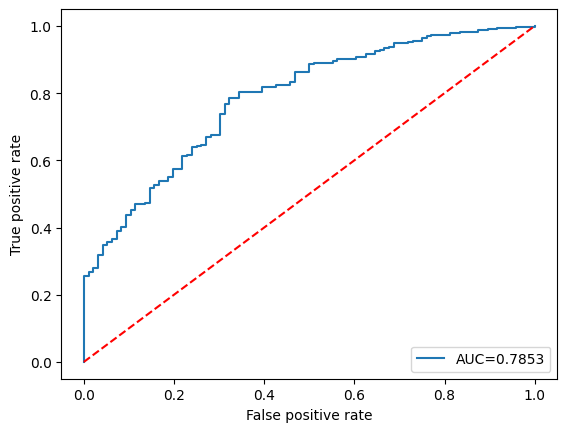

In [73]:
auc_gru_own, acc_gru_own, _ = assess_sentiment_classifier(y_test=y_tweets_test,
                            y_pred_prob = yhat_gru)


In [74]:
df_scores['GRU_own_embeddings'] = [acc_gru_own,auc_gru_own]
df_scores

,Dictionary,TFIDF,GRU_own_embeddings
ACC,0.5720,0.8120,0.8260
AUC,0.6522,0.8454,0.7853


### GRU with Pre-trained Embeddings

In [79]:
!pip install gensim

In [80]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

imdb_index = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size, verbose=0):
    '''
        Helper function to construct an embedding matrix for
        the focal corpus based on some pre-trained embeddings.
    '''

    dim = 0
    if isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))


    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # List for words in our corpus for which we lack a pre-trained embedding.
    oov_words = []
    v = len(tokenizer.word_index)

    for word, i in tokenizer.word_index.items():
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
        # Some output that the method is still alive
        if i % 5000 == 0 and verbose>0:
            print('{}/{} words in {} sec'.format(i, v, (time.time()-start)), flush=True)

    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [ ]:
# Create embedding weight matrix
imdb_embeddings, oov_words = get_embedding_matrix(tok, imdb_index, vocab_word_number)

In [ ]:
# Creating embedding layer using the pre-trained embeddings
pre_trained_emb_layer = Embedding(
    input_dim = vocab_word_number,
    output_dim = imdb_embeddings.shape[1],
    input_length = max_review_length,
    embeddings_initializer = Constant(imdb_embeddings),
    trainable = False
)

In [ ]:
# Pre_trained GRU text classifier
number_hidden_nodes = 20    # number of hidden nodes

pre_trained_gru = Sequential()
pre_trained_gru.add(pre_trained_emb_layer)
pre_trained_gru.add(GRU(number_hidden_nodes, activation = 'relu'))
pre_trained_gru.add(Dropout(0.2))
pre_trained_gru.add(Dense(1, activation = 'sigmoid'))

pre_trained_gru.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
print(pre_trained_gru.summary())

In [ ]:
# fitting the model
nr_epoch = 10
batch_sz = 64
val_split = 0.25
story = pre_trained_gru.fit(x_tweets_train_pad, y_tweets_train, batch_size= batch_sz, epochs= nr_epoch, validation_split=val_split)

In [ ]:
yhat_pre_trained_gru = pre_trained_gru.predict(x_tweets_test_pad)

In [ ]:
auc_pre_trained_gru, acc_pre_trained_gru, _ = assess_sentiment_classifier(y_test=y_tweets_test,
                            y_pred_prob = yhat_pre_trained_gru)

In [ ]:
df_scores['Pre_Trained_GRU'] = [acc_pre_trained_gru,auc_pre_trained_gru]
df_scores

### Sentiment Analysis Using Pre-Trained Transformer Model

In [ ]:
import torch
from transformers import pipeline

classifier = pipeline(
    task="text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation = True
)

In [ ]:
def pipeline_classify(data):
    ''' Function to run the sentiment analysis pipeline on each row of a dataset
    and extract the scores. '''

    scores = []
    for row in data:
      output = classifier(row)[0]
      score = output['score']
      label = output['label']
      score = score if label == 'POSITIVE' else -score
      scores.append(score)

    return scores


In [ ]:
yhat_distilbert = pipeline_classify(x_tweets_clean_test)

In [ ]:
yhat_distilbert_discrete = np.where(pd.DataFrame(yhat_distilbert)>0.5, 1, 0)
acc_distilbert = accuracy_score(y_tweets_test, yhat_distilbert_discrete)
auc_distilbert = roc_auc_score(y_tweets_test, yhat_distilbert_discrete)

In [ ]:
yhat_distilbert_discrete = np.where(pd.DataFrame(yhat_distilbert)>0.5, 1, 0)
auc_distilbert, acc_distilbert, _ = assess_sentiment_classifier(y_test=y_tweets_test,
                            y_pred_prob = yhat_distilbert_discrete)

In [ ]:
df_scores['DistilBert'] = [acc_distilbert,auc_distilbert]
df_scores

### Fine-Tuning Pre-trained Transformer Model

In [ ]:
#Importig Distilbert tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Tokenize training tweetd
x_train_tokenized_distilbert = tokenizer(x_tweets_clean_train.tolist(), truncation=True, padding='max_length')

In [ ]:
#Creating a torch dataset for training

class Tweets_Dataset(torch.utils.data.Dataset):
    def __init__(self, content, sentiment):
        self.content = content
        self.sentiment = sentiment

    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.content.items()}
        item['labels'] = torch.tensor(self.sentiment[idx])
        return item

train_dataset = Tweets_Dataset(x_train_tokenized_distilbert, y_tweets_train.tolist())

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
# set model to use gpu if possible
import torch

if torch.backends.cuda.is_built() and torch.cuda.is_available():
    device = torch.device('cuda') # for NVIDIA GPUs
elif torch.backends.mps.is_built():
   device = torch.device('mps') # for Apple Silicon Macs
else:
    device = torch.device('cpu')

model.to(device)

In [ ]:
# load trainer and set arguments for training
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(

    num_train_epochs = 1,
    per_device_train_batch_size=16,
    learning_rate= 5e-5,
    warmup_steps=500,
    weight_decay=0.01,

    seed=111,
    data_seed=111,
    report_to = 'none'

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset

)


In [ ]:
#trainer.train()

In [ ]:
def predict(input_text : str):
  '''
  Return sentiment score for an input text

  input_text (str) : Input text sequence

  Return:
  int: Sentiment score between 0 and 1

  '''

  encoding = tokenizer(
      input_text,
      truncation = True,
      return_tensors = 'pt'
  )
  with torch.no_grad():
    logits = model(
        encoding.input_ids.to(device),
        encoding.attention_mask.to(device)).logits
  output = softmax(logits.to('cpu'))
  return output.numpy()[0][1]


### Data Frame for Result Comparison

In [ ]:
#Results of different sentiment classifiers in a data frame
df_scores